# Генератор синтетических изображений с номерными знаками Ru

Генератор берет случайное изображение из заданного каталога, генерирует изображения номерного знака, используя изображения символов на номерных знаках (все символы при генерации выбираются случайным образом). После этого изображение номерного знака искажается (шумом, блюром, ресайзом и поворотом вокруг центра) и помещается на исходное изображение в случайное место. 
Номерных знаков на изображении может быть от 1 до 4х.

In [1]:
import cv2
import os 
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import albumentations as A

from tqdm.notebook import trange, tqdm

Определяем директорию с базовыми картинками и подготавливаем список фотографий для генератора

In [2]:
directory = 'data\general_photo' 

In [3]:
files = [os.path.join(directory, i) for i in os.listdir(directory)] 

Определяем вспомогательные функции

In [4]:
def visualize(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
transform_picture = A.Compose([
                                A.RandomRotate90(),
                                A.Flip(),
                                A.Transpose(),
                                A.OneOf([
                                    A.IAAAdditiveGaussianNoise(),
                                    A.GaussNoise(),
                                ], p=0.2),
                                A.OneOf([
                                    A.MotionBlur(p=.2),
                                    A.MedianBlur(blur_limit=3, p=0.1),
                                    A.Blur(blur_limit=3, p=0.1),
                                ], p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                                A.OneOf([
                                    A.OpticalDistortion(p=0.3),
                                    A.GridDistortion(p=.1),
                                    A.IAAPiecewiseAffine(p=0.3),
                                ], p=0.2),
                                A.OneOf([
                                    A.CLAHE(clip_limit=2),
                                    A.IAASharpen(),
                                    A.IAAEmboss(),
                                    A.RandomBrightnessContrast(),            
                                ], p=0.3),
                                A.HueSaturationValue(p=0.3),
                            ])
transform_number = A.Compose([
                                A.OneOf([
                                    A.IAAAdditiveGaussianNoise(),
                                    A.GaussNoise(),
                                ], p=0.7),
                                A.OneOf([
                                    A.MotionBlur(p=.3),
                                    A.MedianBlur(blur_limit=3, p=0.3),
                                    A.Blur(blur_limit=3, p=0.3),
                                ], p=0.5),
                                A.OneOf([
                                    A.IAASharpen(),
                                    A.IAAEmboss(),
                                    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5),            
                                ], p=0.8),
                                A.HueSaturationValue(val_shift_limit=10, p=0.9),
                            ])

Функция добавления шума на изображение:

In [5]:
def make_noisy(image, var):
    row,col,ch= image.shape
    mean = 0
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss

    return noisy

Класс генерируемого изображения:

In [6]:
class pic(object):
    def __init__(self, files):
        self.image_path = self.take_random_pic(files)
#         print(self.image_path)
        self.image = cv2.imread(self.image_path, cv2.IMREAD_UNCHANGED)
        self.image = transform_picture(image=self.image)['image']
        self.image = self.resize(size=(1200, 750))
        self.rectangles = []
        self.numbers = []
        self.numbers_str = []      
    def take_random_pic(self, files):
        random.shuffle(files)
        return files[0]

    def viewImage(self):
        fig, ax = plt.subplots(figsize=(20, 40))
        ax.imshow(cv2.cvtColor(self.image.astype('uint8'), cv2.COLOR_BGR2RGB))

    def resize(self, size=(1200, 750)):
        return cv2.resize(self.image, size)
    
    def add_rectangle(self, rect, x, y):

        b = np.copy(self.image)
        b[y: y + rect.shape[0], x: x + rect.shape[1], :] = rect
        self.image = b
        
    def add_rotated_plate(self, plate):
        
        pl = plate.image
#         print(pl.shape)
        x = random.randint(0,550)
        y = random.randint(0,800)
#         print('x,y', x,y)
#         print('plshpe', pl.shape[0], pl.shape[1])
        image = self.image[x:x+pl.shape[0], y:y+pl.shape[1], :]
        step = 1
#         print('image', image.shape)
        result = image.copy()
        h_ = []
        w_ = []
        for h in range(step, pl.shape[0]):
            for w in range(step, pl.shape[1]):
                s = pl[h-step:h+step+1, w-step:w+step+1, :].sum()
                if s!=0:
                    result[h,w,:] = pl[h,w,:]
                    h_.append(h)
                    w_.append(w)
        self.image[x:x+pl.shape[0], y:y+pl.shape[1], :] = result
        
        if len(h_)==0:
            plate.viewImage()
        
        h_min = min(h_) + x
        h_max = max(h_) + x
        w_min = min(w_) + y
        w_max = max(w_) + y
        self.rectangles.append(((w_min, h_min), (w_max, h_max)))
        self.numbers.append(plate.number)
        self.numbers_str.append(plate.number_str)
        
    def add_rectangles(self):
        result = self.image.copy()
        for r in self.rectangles:
            result = cv2.rectangle(result, r[0], r[1], (255, 0, 0), 2) 
        return result


Класс номерного знака для генератора:

In [7]:
class plate(object):
    def __init__(self):
        self.height = random.randint(40, 100)
        self.width = random.randint(100, 200)
        self.image = cv2.imread(os.path.join('data', 'nomer-rus.jpg'), cv2.IMREAD_UNCHANGED)
        self.number, self.number_str = self.generate_number()
        self.place_number(self.number)
        self.image = transform_number(image=self.image)['image']
        self.image = self.resize(size=(self.width, self.height))
        self.image = self.rotate_plate(self.image, random.randint(-30,30))
        
        

    def generate_number(self):
        digits = list(range(0,10,1))
        letters = list(range(10,22,1))
        region_arr = [45, 12, 123, 76, 163, 116, 31, 66, 164, 89, 
                      159, 85, 36, 11, 64, 74, 190, 23, 43, 71, 17, 32, 
                      154, 127, 142, 8, 77, 33, 88, 29, 5, 16, 22, 14, 125, 
                      41, 55, 54, 102, 173, 138, 46, 91, 18, 82, 75, 96, 94, 
                      13, 81, 62, 80, 67, 51, 56, 40, 79, 38, 44, 1, 134, 39, 28, 
                      113, 95, 178, 97, 27, 10, 73, 58, 6, 136, 57, 72, 35, 174, 9, 
                      70, 34, 86, 26, 7, 24, 750, 121, 68, 197, 53, 196, 177, 52, 61, 
                      19, 186, 2, 4, 93, 199, 25, 37, 87, 152, 30, 47, 84, 48, 126, 65, 
                      83, 60, 21, 124, 99, 92, 98, 63, 49, 15, 161, 150, 69, 90, 42, 777, 
                      3, 59, 50, 169, 78]
        dict_ = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', '8':'8', '9':'9', 
                '10':'A', '11':'B', '12':'C', '13':'E', '14':'H', '15':'K', '16':'M', '17':'O',
                '18':'P', '19':'T', '20':'X', '21':'Y'}
        number = []
        number.append(str(random.choice(letters)))
        number.append(str(random.choice(digits)))
        number.append(str(random.choice(digits)))
        number.append(str(random.choice(digits)))
        number.append(str(random.choice(letters)))
        number.append(str(random.choice(letters)))
        number.append(str(random.choice(region_arr)))
        number_str = ''
        for n in number[:-1]:
            number_str += dict_[n]
        number_str += number[-1]

        return number, number_str 
        
    def add_symbol(self, symbol, x, y, size):
#         print('Adding symbol {}'.format(symbol))
        sample = [os.path.join(os.path.join('data', 'symbols', str(symbol)), i) 
                  for i in os.listdir(os.path.join('data', 'symbols', str(symbol)))]
        rect = cv2.imread(random.choice(sample), cv2.IMREAD_UNCHANGED)
        rect = cv2.resize(rect, size)
        b = np.copy(self.image)
        b[y: y + rect.shape[0], x: x + rect.shape[1], :] = rect
        self.image = b
    
    def place_number(self, number):
        self.add_symbol(number[0], 180, 120, size=(180, 240))
        self.add_symbol(number[1], 400, 30, size=(180, 340))
        self.add_symbol(number[2], 590, 30, size=(180, 340))
        self.add_symbol(number[3], 780, 30, size=(180, 340))
        self.add_symbol(number[4], 1010, 120, size=(180, 240))
        self.add_symbol(number[5], 1200, 120, size=(180, 240))
        # region
        ln = len(str(number[-1]))
        if ln == 1:
            number[-1] = '0'+str(number[-1])
            ln = 2
        for i in range(ln):
            w = (300- (ln-1)*10)//ln 
            h = 210
            self.add_symbol(str(number[-1])[i], 1530+i*(w+10), 60, size=(w, h))
    
    def resize(self, size):
        return cv2.resize(self.image, size)
    
    def rotate_plate(self, plate, angle):
        (h, w, d) = plate.shape
        buffer = np.zeros(shape=(2*h,2*w,d)).astype('uint8')
        buffer[h//2:h//2+h, w//2:w//2+w,:] = plate
        center = (w, h)
        M = cv2.getRotationMatrix2D(center, angle, 0.5)
        rotated = cv2.warpAffine(buffer, M, (2*w, 2*h))
        return rotated
    
    def viewImage(self):
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.imshow(cv2.cvtColor(self.image.astype('uint8'), cv2.COLOR_BGR2RGB))

Формирование списка регионов (закоментировано, т.к. список внесен хардом в класс автономера)

In [8]:
# regions = pd.read_excel(os.path.join('data', 'Kody-regionov-gibdd.xls')).iloc[:,1].to_list()
# regs = []
# for i in [i if str(i).split(', ')==None else str(i).split(', ') for i in regions]:
#     regs.extend(i)
# regs =  [int(i) for i in set(regs)]
# print(regs)

Функция генерации изображения с номерными знаками:

In [9]:
def make_img_with_plates(files):
    picture = pic(files)
    n = random.randint(1,4)
    plates = []
    for i in range(n):
        p = plate()
        plates.append(p)
        if p.image.sum()==0:
            continue
        picture.add_rotated_plate(p)
        
        
    return picture, plates 

Тестовая генерация 3 изображений:

  0%|          | 0/3 [00:00<?, ?it/s]

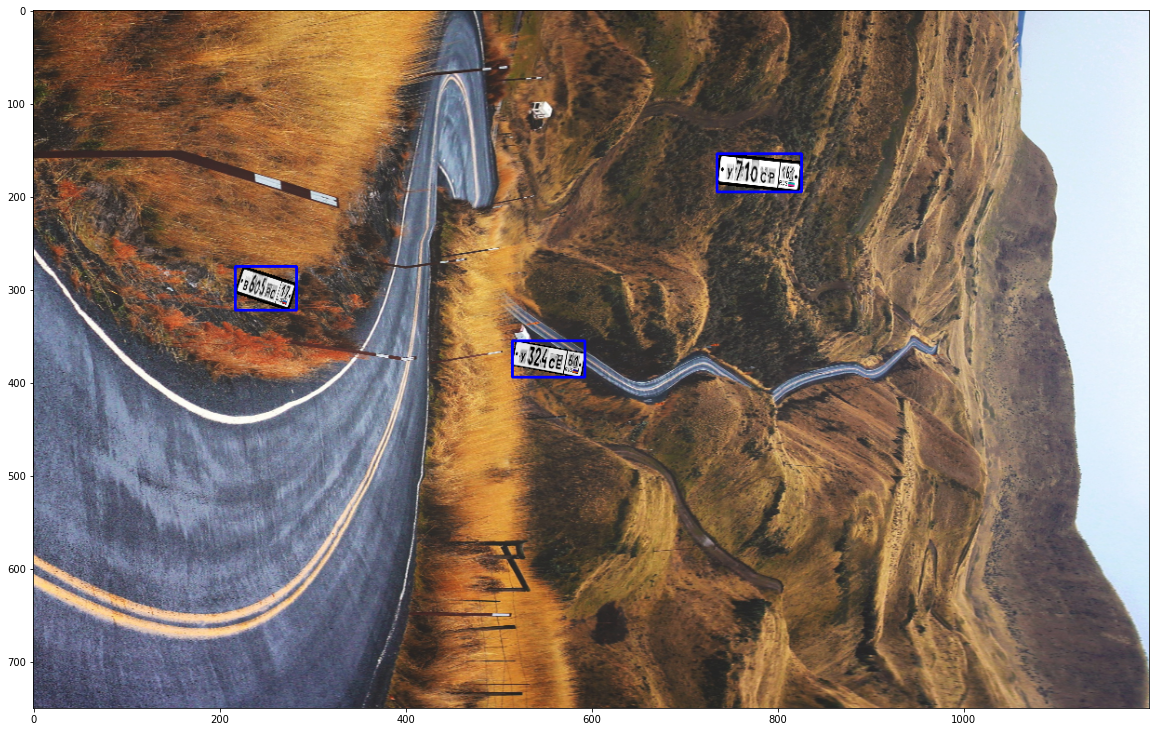

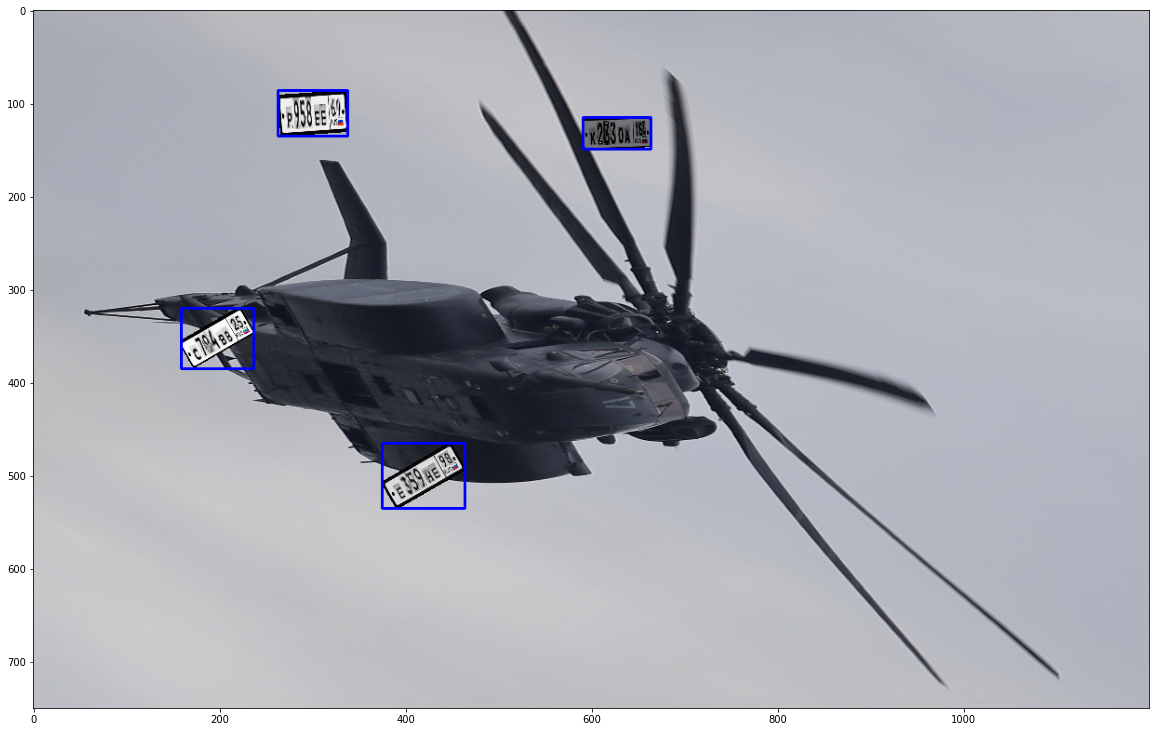

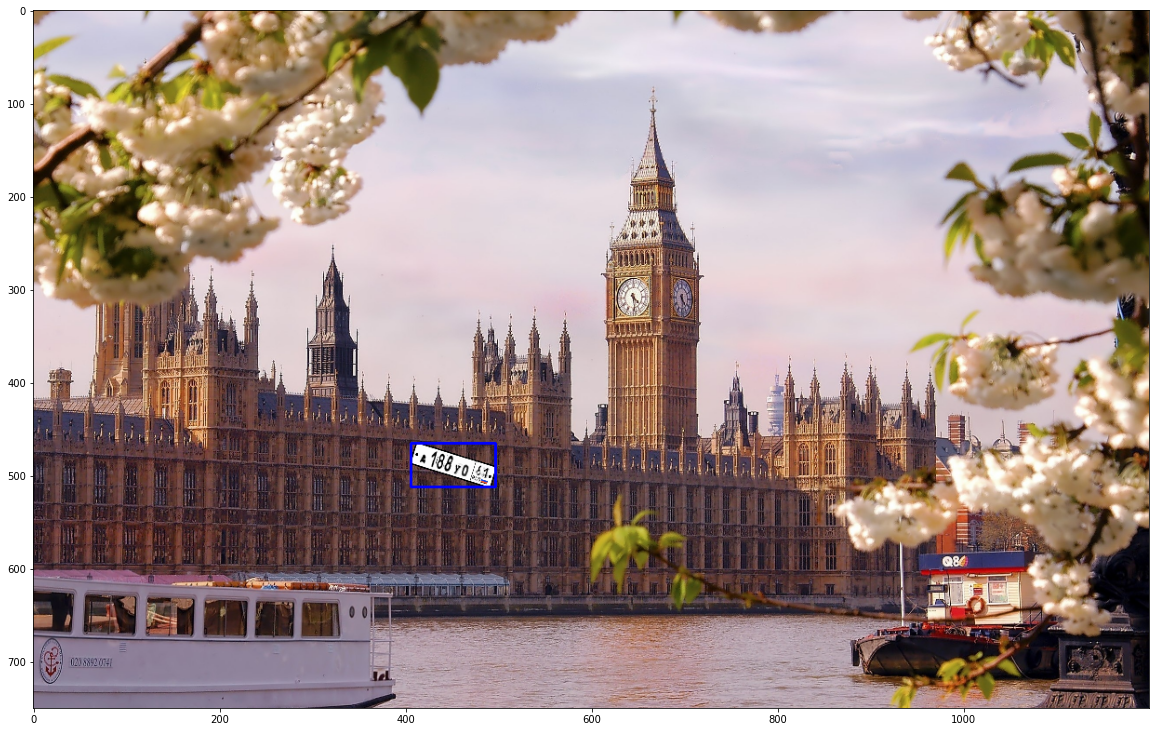

In [10]:
for i in tqdm(range(3)):
    new_pic, _ = make_img_with_plates(files)
    new_pic = new_pic.add_rectangles()
    fig, ax = plt.subplots(figsize=(20, 40))
    ax.imshow(cv2.cvtColor(new_pic.astype('uint8'), cv2.COLOR_BGR2RGB))

Генерируем 10000 изображений и формируем аннотацию:

In [11]:
N = 0
def make_annotation(pict, n):
    annot = {}
    an = []
    for i, r in enumerate(pict.rectangles):
        an.append({
                    "class": "rect",
                    "width": r[1][0]-r[0][0] ,
                    "height": r[1][1]-r[0][1],
                    "x": (r[1][0]+r[0][0])/2,
                    "y": (r[1][1]+r[0][1])/2,
                    "number": pict.numbers_str[i]})
    annot['annotation'] = an
    annot['class'] = 'image'
    annot['filename'] = "data\\synthetic_val\\"+"image_"+str(N)+"_"+str(n)+".JPG"
    return annot

In [12]:
if N==0:
    annotations = []
p_bar = tqdm(range(100))
for n in p_bar:
    pict, plates = make_img_with_plates(files)
    annot = make_annotation(pict, n)
    cv2.imwrite(annot['filename'], pict.image)
    annotations.append(annot)


  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
len(annotations)

100

In [14]:
import json
with open(os.path.join('data', 'syn_val_autonumber_annotations.json'), "w", encoding="utf-8") as file:
    json.dump(annotations, file)